### TUTORIAL

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.utils import Bunch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
import nltk
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import numpy as np 

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
categories = ["not_sexist", "sexist"]
#               2161           989

In [3]:
data = pd.read_csv("my_csv.csv",sep = ',')
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class']

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

### Tokenizing text with scikit-learn

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(2204, 11264)

In [5]:
count_vect.vocabulary_.get(u'femme')

4014

### From occurrences to frequencies

In [6]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2204, 11264)

### Training a classifier

In [7]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
docs_new = ["Les hommes c'est tous les mêmes", 'Il est étudiant.'] #marche pas du tout
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))

"Les hommes c'est tous les mêmes" => not_sexist
'Il est étudiant.' => not_sexist


### Building a pipeline

In [9]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', MultinomialNB()),
... ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation of the performance on the test set

In [10]:
docs_test = X_test
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.6984126984126984

### SVM

In [11]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)),
... ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.7534391534391535

In [12]:
print(metrics.classification_report(y_test, predicted,
...     target_names=categories))

              precision    recall  f1-score   support

  not_sexist       0.77      0.91      0.83       644
      sexist       0.68      0.43      0.52       301

    accuracy                           0.75       945
   macro avg       0.73      0.67      0.68       945
weighted avg       0.74      0.75      0.73       945



In [13]:
metrics.confusion_matrix(y_test, predicted)

array([[584,  60],
       [173, 128]], dtype=int64)

### Parameter tuning using grid search

In [14]:
parameters = {
...     'vect__ngram_range': [(1, 1), (1, 2)],
...     'tfidf__use_idf': (True, False),
...     'clf__alpha': (1e-2, 1e-3),
... }

In [15]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [16]:
gs_clf = gs_clf.fit(X_train[:100], y_train[:100])
#ameliorer vecteur et algo et representation
#-> plus de poids sur les mots sexistes

In [17]:
example_1 = 'La femme'
example_2 = "L'homme"
example_3 = "La femme doit être dans la cuisine"

print(example_1 + "  => " + str(categories[gs_clf.predict([example_1])[0]]))
print(example_2 + "  => " + str(categories[gs_clf.predict([example_2])[0]]))
print(example_3 + "  => " + str(categories[gs_clf.predict([example_3])[0]]))

La femme  => not_sexist
L'homme  => sexist
La femme doit être dans la cuisine  => sexist


In [18]:
gs_clf.best_score_

0.8099999999999999

In [19]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 2)


### Oversampling

In [20]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({1: 1516, 0: 1516})


In [21]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(3032, 11264)

In [22]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3032, 11264)

In [23]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_ros_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)

"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7360248447204969


array([[402, 242],
       [ 98, 546]], dtype=int64)

### Undersampling

In [24]:
# instantiating the random over sampler 
ros = RandomUnderSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({0: 688, 1: 688})


In [25]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1376, 8003)

In [26]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1376, 8003)

In [27]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7325581395348837


array([[184, 117],
       [ 44, 257]], dtype=int64)

### Oversampling and Undersampling

In [28]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)

In [29]:
X_over, y_over = over.fit_resample(np.array(X_train).reshape(-1,1), y_train)
print(f"Oversampled: {Counter(y_over)}")

Oversampled: Counter({0: 1516, 1: 758})


In [30]:
# now to comine under sampling 
X_ros, y_ros = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_ros)}")

Combined Random Sampling: Counter({0: 947, 1: 758})


In [31]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1705, 9175)

In [32]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1705, 9175)

In [33]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."]
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7308970099667774


array([[244,  57],
       [105, 196]], dtype=int64)

### Word Embedding using Doc2Vec

###### 1st Step : Getting cleaned data

In [3]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

###### 2nd step : Keeping a tokenized version of the sentences and the corresponding categories

In [4]:
X_tokenized = []
y_tokenized = []

for sentence in X_train:
    X_tokenized.append(word_tokenize(sentence))    
    
for cat in y_train:
    y_tokenized.append(cat)

###### 3rd step : Defining a cosine function to compute the similaity between two vectors

In [5]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

###### 4th step : Building a tagged sentence corpus

In [6]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(X_tokenized)]
tagged_data

[TaggedDocument(words=['nouveau', 'coup', 'de', 'coeur', 'igit', 'noir', 'blanc', 'duo', 'avec', 'catherine', 'deneuve', 'deezer'], tags=[0]),
 TaggedDocument(words=['darmanin', 'contribution', 'de', 'journée', 'pour', 'macron', 'edouardphilippe', 'balancetonporc'], tags=[1]),
 TaggedDocument(words=['flash', 'lallemagne', 'assure', 'ne', 'participera', 'pas', 'frappe', 'contre', 'syrie', 'de', 'même', 'canada', 'angela', 'merkel', 'affirme', 'toutefois', 'quil', 'paraît', 'évident', 'gouvernement', 'syrien', 'na', 'pas', 'détruit', 'toutes', 'armes', 'chimiques', 'médias', 'allemands', 'assad'], tags=[2]),
 TaggedDocument(words=['humour', 'langues', 'délient', 'ça', 'ne', 'plaît', 'pas', 'tout', 'monde', 'balancetonporc'], tags=[3]),
 TaggedDocument(words=['eh', 'bas', 'moi', 'trouve', 'au', 'contraire', 'friends', 'est', 'fait', 'réaliste', 'on', 'dénonce', 'aujrd', 'situations', 'problématiques', 'homotransphobie', 'sexisme', 'grossophobie', 'on', 'aurait', 'pas', 'dénoncer', 'si', '

###### 5th step : train the model

In [7]:
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

###### 6th step : testing the model

In [12]:
def predicted_category(sentence):
    sentence = sentence.lower()
    test_doc = word_tokenize(sentence)
    test_doc_vector = model.infer_vector(test_doc)
    similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector]) 
    similar_senetences_categories = [y_tokenized[similar_sentences[i][0]] for i in range(len(similar_sentences))]

    nb_0 = similar_senetences_categories.count(0)
    nb_1 = similar_senetences_categories.count(1)
    
    if(nb_0 <= nb_1):
        return 1
    
    else:
        return 0

    
predictions = []    
for sentence in X_test:
    predictions.append(predicted_category(sentence))
  
print("Accuracy : ", np.mean(predictions == y_test))
metrics.confusion_matrix(y_test, predictions)

<ipython-input-12-8751669f327c>:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector])


Accuracy :  0.656084656084656


array([[500, 132],
       [193, 120]], dtype=int64)

### Word Embedding using tensorflow keras

In [40]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [41]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

sentences = list(data['tweet'])
labels = [categories[i] for i in data['class']]

print(labels)

['not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_

In [42]:
#splitting dataset
train_size = int(len(sentences) * training_portion)
train_sentences = sentences[:train_size] #X_train
train_labels = labels[:train_size] #y_train
validation_sentences = sentences[train_size:] #X_test

validation_labels = labels[train_size:] #y_test
print(train_labels)

['not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_

In [43]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

In [44]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

11475
{'<OOV>': 1, 'de': 2, 'pour': 3, 'balancetonporc': 4, 'du': 5, 'qui': 6, 'pas': 7, 'sur': 8, 'dans': 9, 'est': 10, 'sexisme': 11, 'moiaussi': 12, 'femme': 13, 'au': 14, 'ce': 15, 'avec': 16, 'ne': 17, 'par': 18, 'on': 19, 'femmes': 20, 'plus': 21, 'cest': 22, 'il': 23, 'contre': 24, 'vous': 25, 'metoo': 26, 'merkel': 27, 'ça': 28, 'mais': 29, 'fait': 30, 'via': 31, 'comme': 32, '»': 33, 'nous': 34, 'angela': 35, '«': 36, 'aux': 37, 'sont': 38, 'cette': 39, 'ou': 40, 'si': 41, 'tout': 42, 'sexiste': 43, 'elle': 44, 'monde': 45, 'ensemblecontrelesexisme': 46, 'ont': 47, 'après': 48, 'bleues': 49, 'mouvement': 50, 'ironie': 51, 'viol': 52, 'faire': 53, 'bien': 54, 'etmaintenant': 55, 'leur': 56, 'quand': 57, 'y': 58, 'france': 59, 'même': 60, 'aussi': 61, 'royal': 62, 'journée': 63, 'c’est': 64, 'harcèlement': 65, 'suis': 66, 'match': 67, 'macron': 68, 'être': 69, 'merci': 70, 'ségolène': 71, 'hommes': 72, 'me': 73, 'été': 74, 'tous': 75, 'travail': 76, 'notre': 77, 'non': 78, 'may'

In [45]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)



NameError: name 'validation_sequences' is not defined

In [ ]:
print(len(train_sentences[1]))
print(len(train_sequences[1]))
print(len(train_padded[1]))
print()
print(train_sentences[1])
print(train_sequences[1])
print(train_padded[1])

In [ ]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
print(training_label_seq)
print(training_label_seq.shape)
print(type(training_label_seq[0]))


In [ ]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata

### TEST 

In [209]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [210]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexi

In [211]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [212]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

10539
{'<OOV>': 1, 'de': 2, 'pour': 3, 'balancetonporc': 4, 'du': 5, 'pas': 6, 'qui': 7, 'femme': 8, 'est': 9, 'sur': 10, 'dans': 11, 'sexisme': 12, 'ce': 13, 'au': 14, 'avec': 15, 'ne': 16, 'moiaussi': 17, 'on': 18, 'cest': 19, 'il': 20, 'plus': 21, 'femmes': 22, 'par': 23, 'vous': 24, 'ça': 25, 'mais': 26, 'contre': 27, 'fait': 28, 'metoo': 29, 'comme': 30, 'sexiste': 31, 'elle': 32, 'merkel': 33, '«': 34, 'sont': 35, '»': 36, 'ou': 37, 'si': 38, 'via': 39, 'tout': 40, 'nous': 41, 'aux': 42, 'cette': 43, 'angela': 44, 'faire': 45, 'viol': 46, 'bien': 47, 'après': 48, 'quand': 49, 'aussi': 50, 'c’est': 51, 'me': 52, 'même': 53, 'monde': 54, 'ironie': 55, 'ensemblecontrelesexisme': 56, 'suis': 57, 'hommes': 58, 'ont': 59, 'y': 60, 'harcèlement': 61, 'homme': 62, 'france': 63, 'mouvement': 64, 'leur': 65, 'bleues': 66, 'etmaintenant': 67, 'merci': 68, 'été': 69, 'moi': 70, 'royal': 71, 'enceinte': 72, 'être': 73, 'va': 74, 'non': 75, 'jai': 76, 'dit': 77, 'ans': 78, 'fille': 79, 'pourqu

In [213]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)


In [214]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))



In [215]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dense_15 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [216]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 2s - loss: 1.6562 - accuracy: 0.3132 - val_loss: 1.4296 - val_accuracy: 0.3164 - 2s/epoch - 22ms/step
Epoch 2/30
69/69 - 0s - loss: 1.0907 - accuracy: 0.4893 - val_loss: 0.7843 - val_accuracy: 0.6836 - 271ms/epoch - 4ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6937 - accuracy: 0.6868 - val_loss: 0.6527 - val_accuracy: 0.6836 - 326ms/epoch - 5ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6399 - accuracy: 0.6868 - val_loss: 0.6352 - val_accuracy: 0.6836 - 269ms/epoch - 4ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6290 - accuracy: 0.6868 - val_loss: 0.6298 - val_accuracy: 0.6836 - 360ms/epoch - 5ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6257 - accuracy: 0.6868 - val_loss: 0.6267 - val_accuracy: 0.6836 - 308ms/epoch - 4ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6220 - accuracy: 0.6868 - val_loss: 0.6235 - val_accuracy: 0.6836 - 350ms/epoch - 5ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6198 - accuracy: 0.6868 - val_loss: 0.6215 - val_accuracy: 0.6836 - 284ms/epoch - 4ms/step
Epoch 9/30
69/69 -

In [217]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

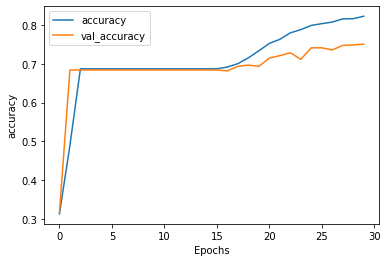

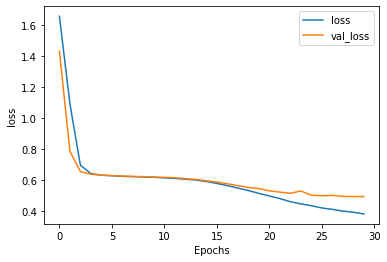

In [218]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [168]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [169]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [170]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata

In [230]:
y_pred = model.predict(validation_padded)
#print(validation_padded.shape)
print(validation_label_seq.shape)
print(y_pred.shape)

#print(y_pred)
print(y_pred)
#confusion_matrix = tf.math.confusion_matrix(labels=validation_label_seq, predictions=y_pred)


(945, 1)
(945, 6)
[[1.98611979e-05 7.52756000e-01 2.47027114e-01 7.55505389e-05
  6.44062820e-05 5.70579687e-05]
 [1.03955945e-05 8.91364038e-01 1.08516552e-01 4.26884872e-05
  3.51699236e-05 3.10845971e-05]
 [1.54580503e-05 7.44475067e-01 2.55351275e-01 6.07344664e-05
  5.19361674e-05 4.55623012e-05]
 ...
 [8.17735054e-05 1.86627433e-01 8.12639117e-01 2.33964485e-04
  2.20763613e-04 1.96997004e-04]
 [3.48673784e-05 7.59568810e-01 2.40071580e-01 1.23904276e-04
  1.05827938e-04 9.50479298e-05]
 [1.43888810e-05 7.61226356e-01 2.38611102e-01 5.70549855e-05
  4.84501179e-05 4.27002706e-05]]


### Adding weight to the sexist words using tf-idf 

In [13]:
import re

stereotype_liste = []

with open('stereotype_liste.txt',encoding='utf8') as f:
    stereotype_liste = f.readlines()
  


weighted_words = [re.sub(r"\n",'',i) for i in stereotype_liste]


print(weighted_words)


['femme', 'fille', 'nana', 'meuf', 'chienne', 'poule', 'garce', 'femelle', 'princesse', 'chose', 'fillette', 'femme objet', 'femme-objet', 'objet', 'ruminante', 'bonne femme', 'potiche', 'biche', 'cocotte', 'journaleuse', 'sex symbol', 'sex symbole', 'daronne', 'diablesse', 'macrelle', 'gonzesse', 'miss', 'femme parfaite', 'dinde', 'feumeu', 'sainte', 'beurette', 'hardeuse', 'dame', 'madame', 'petite dame', 'vraie femme', 'pauvre femme', 'lesbienne ', 'conne', 'connasse', 'cageot', 'casse-bonbon', 'casse-couille', 'casse-couilles', 'chiennasse', 'chienne', 'emmerdeuse', 'folle', 'garage à bite', 'garce', 'gouine', 'gourdasse', 'gourde', 'morue', 'pétasse', 'pouf', 'pouffiasse', 'poufiasse', 'pute', 'salope', 'sorcière', 'traînée', 'vipère', 'bonne', 'petite', 'moche', 'vieille', 'bombe', 'poitrine', 'sein', 'fesses', 'cul', 'grosse', 'vache', 'truie', 'boudin', 'jupe', 'minijupe ', 'mini-jupe', 'robe', 'décolleté', 'cuisses', 'sexy', 'chatte', 'maquillage', 'baleine', 'belle', 'coquett

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
   
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

vectorizer = TfidfVectorizer()
new_X = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()


array(['000', '02', '04', ..., 'œuvrer', 'œuvres', 'بادمافاتيسئللمسلمين'],
      dtype=object)

### Naive Bayes classifier

In [365]:
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_0 = []
X_1 = []
for i in range(len(data)):
    if data['class'][i]==0:
        X_0.append(data['tweet'][i])
        
for i in range(len(data)):
    if data['class'][i]==1:
        X_1.append(data['tweet'][i])



vec_0 = CountVectorizer()
X_c0 = vec_0.fit_transform(X_0)
tdm_0 = pd.DataFrame(X_c0.toarray(), columns=vec_0.get_feature_names())


vec_1 = CountVectorizer()
X_c1 = vec_1.fit_transform(X_1)
tdm_1 = pd.DataFrame(X_c1.toarray(), columns=vec_1.get_feature_names())

tdm_1


C:\Users\evara\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,02,04,06,10,100,1000,102,12,120,12000,...,éviter,évoluent,évoluer,évoquer,êtes,être,êtres,êtreunefemme,ģarrido,بادمافاتيسئللمسلمين
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [366]:
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_c0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))
freq_0

C:\Users\evara\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'000': 4,
 '04': 1,
 '05': 1,
 '10': 7,
 '100': 10,
 '1000': 1,
 '102': 2,
 '10h': 2,
 '10h00': 1,
 '10h30': 1,
 '11': 3,
 '1100': 1,
 '11000': 1,
 '117': 1,
 '12': 8,
 '1200': 1,
 '12000': 1,
 '120battementsparminute': 1,
 '1215': 1,
 '12h': 1,
 '12joursdaction': 1,
 '13': 7,
 '13h50': 1,
 '14': 9,
 '14h': 1,
 '14h00': 1,
 '14h15': 2,
 '14ème': 1,
 '15': 11,
 '157garlamd': 1,
 '15min': 1,
 '15x': 1,
 '16': 4,
 '169': 1,
 '16days': 2,
 '16h': 3,
 '16jours': 3,
 '17': 7,
 '1700': 1,
 '1703': 1,
 '1730': 1,
 '18': 9,
 '180': 1,
 '18006675005': 1,
 '18006686868': 1,
 '1825': 1,
 '18711955': 1,
 '18h': 2,
 '18h00': 1,
 '18h30': 1,
 '18h55': 1,
 '19': 6,
 '1900': 1,
 '1904': 1,
 '1905': 1,
 '1920': 2,
 '1927': 2,
 '1929': 2,
 '195': 2,
 '1954': 1,
 '1962': 1,
 '1965': 1,
 '1970': 1,
 '1979': 1,
 '1986': 1,
 '1987': 1,
 '1992': 1,
 '1999': 1,
 '19e': 1,
 '19h': 1,
 '19h30': 1,
 '19hruthelkrief': 2,
 '1a0maiscpasperdu': 1,
 '1dexmab': 1,
 '1dexmag': 1,
 '1e': 1,
 '1er': 10,
 '1ere': 5,
 '1ir

In [367]:
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_c1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))
freq_1

{'02': 3,
 '04': 3,
 '06': 1,
 '10': 6,
 '100': 2,
 '1000': 1,
 '102': 1,
 '12': 5,
 '120': 2,
 '12000': 1,
 '12f': 1,
 '13': 4,
 '14': 3,
 '14amp15': 1,
 '14ans': 1,
 '15': 2,
 '150': 1,
 '15ans': 1,
 '16': 2,
 '16ans': 1,
 '16days': 2,
 '16jours': 3,
 '17': 1,
 '1964': 1,
 '1990': 1,
 '1992': 2,
 '1997': 2,
 '1998': 1,
 '1999': 1,
 '1cm': 1,
 '1dexmag': 1,
 '1er': 1,
 '1ere': 1,
 '1ère': 2,
 '20': 7,
 '2004': 1,
 '2005': 1,
 '2006': 1,
 '2011': 1,
 '20122017': 1,
 '2014': 1,
 '2015': 2,
 '2016': 2,
 '2017': 9,
 '2018': 15,
 '20ans': 1,
 '20hfrance2': 1,
 '20minutes': 2,
 '21': 2,
 '21ème': 2,
 '22': 4,
 '23': 1,
 '24': 1,
 '2499': 1,
 '24hpujadas': 1,
 '25': 2,
 '25janvier': 2,
 '26': 1,
 '26caroll': 1,
 '27': 2,
 '28': 1,
 '2choses': 1,
 '2h': 1,
 '30': 4,
 '31': 1,
 '32': 1,
 '36': 1,
 '3600x': 1,
 '364': 1,
 '3784e': 1,
 '38': 2,
 '3min': 1,
 '3ème': 1,
 '40': 1,
 '40t': 1,
 '44': 1,
 '44t': 1,
 '4h': 1,
 '4m': 1,
 '50': 5,
 '500': 1,
 '5000': 1,
 '50100500': 1,
 '50euros': 1,
 '5

In [368]:
prob_0 = []
for word,count in zip(word_list_0,count_list_0):
    prob_0.append(count/len(word_list_0))
dict(zip(word_list_0,prob_0))


{'000': 0.00041076196344218524,
 '04': 0.00010269049086054631,
 '05': 0.00010269049086054631,
 '10': 0.0007188334360238242,
 '100': 0.0010269049086054631,
 '1000': 0.00010269049086054631,
 '102': 0.00020538098172109262,
 '10h': 0.00020538098172109262,
 '10h00': 0.00010269049086054631,
 '10h30': 0.00010269049086054631,
 '11': 0.00030807147258163895,
 '1100': 0.00010269049086054631,
 '11000': 0.00010269049086054631,
 '117': 0.00010269049086054631,
 '12': 0.0008215239268843705,
 '1200': 0.00010269049086054631,
 '12000': 0.00010269049086054631,
 '120battementsparminute': 0.00010269049086054631,
 '1215': 0.00010269049086054631,
 '12h': 0.00010269049086054631,
 '12joursdaction': 0.00010269049086054631,
 '13': 0.0007188334360238242,
 '13h50': 0.00010269049086054631,
 '14': 0.0009242144177449168,
 '14h': 0.00010269049086054631,
 '14h00': 0.00010269049086054631,
 '14h15': 0.00020538098172109262,
 '14ème': 0.00010269049086054631,
 '15': 0.0011295953994660095,
 '157garlamd': 0.0001026904908605463

In [369]:
prob_1 = []
for word,count in zip(word_list_1,count_list_1):
    prob_1.append(count/len(word_list_1))
dict(zip(word_list_1,prob_1))


{'02': 0.0005089921954530031,
 '04': 0.0005089921954530031,
 '06': 0.00016966406515100103,
 '10': 0.0010179843909060061,
 '100': 0.00033932813030200206,
 '1000': 0.00016966406515100103,
 '102': 0.00016966406515100103,
 '12': 0.0008483203257550051,
 '120': 0.00033932813030200206,
 '12000': 0.00016966406515100103,
 '12f': 0.00016966406515100103,
 '13': 0.0006786562606040041,
 '14': 0.0005089921954530031,
 '14amp15': 0.00016966406515100103,
 '14ans': 0.00016966406515100103,
 '15': 0.00033932813030200206,
 '150': 0.00016966406515100103,
 '15ans': 0.00016966406515100103,
 '16': 0.00033932813030200206,
 '16ans': 0.00016966406515100103,
 '16days': 0.00033932813030200206,
 '16jours': 0.0005089921954530031,
 '17': 0.00016966406515100103,
 '1964': 0.00016966406515100103,
 '1990': 0.00016966406515100103,
 '1992': 0.00033932813030200206,
 '1997': 0.00033932813030200206,
 '1998': 0.00016966406515100103,
 '1999': 0.00016966406515100103,
 '1cm': 0.00016966406515100103,
 '1dexmag': 0.00016966406515100

In [370]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)
X_train_0 = []
X_train_1 = []
print(X_train)
print(X_train.index)

index =  X_train.index
for i in index:
    if (y_train[i]==0):
        X_train_0.append(X_train[i])
    else:
        X_train_1.append(X_train[i])
        

        



951     soutienpoursusie 13 ans intolérable acquitteme...
191     donc laisses pesticide interdit circuler libre...
529     argentine58 skoupika danieljfpin kilowattkyr l...
2969    lamentable déferlement de propos sexistes miso...
1089    vendredi théorie parlons violences caractère s...
                              ...                        
1040    vous pensiez balancetonporc jeu télé ou lon la...
259     retweeted nils wilcke pauldenton sandra muller...
2237    ne veux pas nécessairement de femme prêtres ma...
909                 aurore bergé sexprime sur harcèlement
390     qd mn ex afghanistan jregardais svt vidéos de ...
Name: tweet, Length: 2203, dtype: object
Int64Index([ 951,  191,  529, 2969, 1089, 1044, 2124, 1037, 2632, 1324,
            ...
             844, 3079,   36, 1692, 1080, 1040,  259, 2237,  909,  390],
           dtype='int64', length=2203)


In [371]:
vec_0 = CountVectorizer()
X_vec_0 = vec_0.fit_transform(X_train_0)

total_features0 = len(vec_0.get_feature_names())
total_features0
proba0 = total_features0 / (total_features0+total_features1)
proba0

0.6260883717145415

In [372]:
vec_1 = CountVectorizer()
X_vec_1 = vec_1.fit_transform(X_train_1)

total_features1 = len(vec_1.get_feature_names())
total_features1

proba1 = total_features1 / (total_features0+total_features1)
proba1

0.3713538687801291

In [373]:
total_cnts_features_0 = count_list_0.sum(axis=0)
total_cnts_features_1 = count_list_1.sum(axis=0)

In [374]:
from nltk.tokenize import word_tokenize
new_sentence = 'what is the price of the book'
new_word_list = word_tokenize(new_sentence)

In [375]:
def proba_sentence_class0(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_0.keys():
            count = freq_0[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_0 + total_features))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba0
    return res
  

In [376]:
def proba_sentence_class1(sentence):
    new_word_list = word_tokenize(sentence)
    prob_s_with_ls = []
    for word in new_word_list:
        if word in freq_1.keys():
            count = freq_1[word]
        else:
            count = 0
        prob_s_with_ls.append((count + 1)/(total_cnts_features_1 + total_features))
    d = dict(zip(new_word_list,prob_s_with_ls))
    res = 1
    for word in sentence.split():
        res = res * d[word]

    res = res * proba1
    return res

print(proba_sentence_class1("what is the price of the book"))

7.724298117612517e-32


In [377]:
predictions = []
for i in X_test:
    print(i)
    proba_class0 = proba_sentence_class0(i)
    proba_class1 = proba_sentence_class1(i)
    if proba_class0 > proba_class1:
        predictions.append(0)
    else:
        predictions.append(1)
        
print(predictions)

ne fais pas lamour baise brutalement balancetonporc 50nuancesdegrey
thuram décoré pour lensemble de œuvre st 2 ou 3 bleus sur femme face lutte contre racisme francecroatie ironie
palmarès politique social 2017 moiaussi paradisepapers coulepascheznous valérieplante polqc polcan assnat
gwgoldnadel voyons william cest femme cest pas moment te dis 2 poids 2 mesures trump pour avoir dit dune journaliste excited devait avoir règles traîne énorme casserole après mslms femmes
100 femmes dénoncent mouvement moiaussi france mal de cœur moiaussi
bleues qualifient finale de cdm de handball saintetienne club historique du championnat est train de couler dimanche il y plus gros match du championnat on met quoi mecs neymar allez go
chronique très intimiste dans lactualite metoo moiaussi
sacheter boisson briochedore garedelyon ressentir viol 365€
p louis b sagez du syndicatcftc ont rencontré vendredi dernier ministre du travail titre sexiste bfmtv
féministes peuventelles parler très bon texte réponse 

valérie pécresse dit quoi de mieux quune femme pour faire ménage leçon de féminisme droitdesfemmes directidf
par contre cette année ne ferai pas conne jirai acheter ventilateur très tôt
angela merkel pas de participation de lallemagne frappes syrie
balancetonporc collectif feministe contre viol
twitter me dégoûte quand france est du côté pedophiles boycotttpmp jeremstargate babargate balancetonporc
fpasquisdumont bien nous soyons iledefrance notre étude couvre manuels de toutes nos régions ensemblecontrelesexisme
homme intervenant sur braquage tué femme enceinte touchée tête par tir de plomb cafaitdesbonnesvacances lt
angela merkel pris parole cet aprèsmidi retour sur points clés de discours linfoduvrai
itele antisemite haha bientot crif ldj viendrons sonner porte pour enlever femme enfant ose critique israël ironie
darmanin accusé faits qui remontent quand javais 25 ans nétais rien largument faits anciens été souvent utilisé pour minimiser mais pourquoi glisser vu selon ministre il ne

hayvanazad shabille comme grosse pute ou pas ca change rien au viol trouve abi
on dira désormais jaune est couleur de lamour après moiaussi milliers de signatures pour déclaration etmaintenant ode au respect légalité genres
donc gouvernements venir expliqueront aux bébés devenus ados letat français de macron choisi délibérément de ne pas lui donner de père de mère ou 2 au nom de légalité hommefemme lui na aucun droit sauf dêtre jouet de parents adoptifs
tout travail dangela merkel de lallemagne été balayé par immigrationnisme non nous ne pouvons pas remercier sur ce sujet qui est grave erreur de gestion politique envers peuples deurope
communique de presse est sorti de presse tlmep moiaussi
metoo violences violencesfaitesaufemmes sexisme rennes elles refusent insultes deux jeunes femmes tabassées
8218 19h30 soiréedébat inégalités daujourdhui sources différentes même combat organisée par collroosevelt belleville présentation du qsjinegalites aux editionspuf discussion avec passansnous a

+1 cest valable pour toutes discriminations systémiques sexisme racisme validisme dont psychophobie lgbtphobies dont l homophobie etc si vous nêtes pas ou navez pas été concernées écoutez celleux qui sont ou lont été
via lacroix comment mettre hors jeu sexisme dans sport
vous présente porcinet nouveau compagnon pour cours balancetonporc
jeremstar ne suis pas violeur mère est femme balancetonporc de rien malaise – jeremstar palpe poitrine dune jeune femme public sur snapchat ne te permet pas il continue lhumilie
quand te fais violer alors tétais jean police doute sur toi balancetonporc
face au sexisme revoir léducation garçons
violences sexuelles dans sport témoignages région balancetonporc sport
affaire buttet votre avis nous intéresse buttet harcelement balancetonporc valais politique suisse moiaussi metoo balancetatruie
félicitations bnpparibas sogeti davoir pris devants sensibilisé leurs rh managers détection prévention du sexisme du harcèlementsexuel
trump toujours obsédé par obama

egalité hommefemme négociation plutôt quune loi
conclusion ce sont porcs qui ruinent sexe pas celles qui balancent metoo balancetonporc
balancetonporc dénoncer actes pédophiles qui leur sont avoués dans secret du confessionnal prêtres qui sy risqueraient seraient punis dexcommunication balancetonporc balancetonpedo dieu protège tout monde sauf victimes
facebook censuré teaser de notre websérie car on y voit seins si on arrêtait de systématiquement sexualiser corps de femme il ny absolument rien dobscène montrer lanatomie humaine sexismeordinaire sexisme sexualisation femmes discrimination
jeremstargate manque de seins de pussy sexisme
mariage pour tous sous présidence de françois hollande 20122017 il de responsabilité politique éthique de porter avec courage cette réforme qui partage étend libertés christiane taubira garde sceaux chargée de mener bien
pote vient de roter rom1marco balancetonporc
briefing équipes de salle avant dîner offert lhonneur de excellence theresa may chefelysee


ça me désole de voir point sexualité de femme est encore ultra tabou si femme envie de faire soulever ou fait soulever autant de fois veut force elle detre épanouie sexuellement bordel ya aucun sale pute ou salope qui tienne
présent au groupe de travail lutte contre sexisme harcelement toutes formes de discriminations avec lafhf cpuniversite aphp isnitwit karinelacour kevinneuville doyenne dentaire dir aff méd dg ch drh chu dg fp estfhf tous unis pour légalité
finir avec clichés sur femmes au volant sexisme égalitéfh automobile
quatre adolescentes poursuivent frappent jeune femme dans métro via 20minutes
portrait 🙌🏽✨ féministe décoloniale founé est jeune inspirante qui nous livre dans cet article parcours difficultés subies tant femme noire musulmane vivant dans quartier populaire 📣👩🏿💪🏿✍🏿
quand mec entend marleneschiappa parler dégalité femmeshommes de feminisme ou pire de sexisme balancetonporc metoo
selon canard enchaîné sarkozy aurait dit wauquiez beaucoup de monde me disait nétais 

In [378]:
total_labels = len(y_test)
acc = 0
for i in range(len(y_test)):
    if(y_test[y_test.index[i]]==predictions[i]):
        acc = acc + 1
        
acc = acc / total_labels
print("Accuracy :" , acc)
        
metrics.confusion_matrix(y_test, predictions)

Accuracy : 0.9248677248677248


array([[575,  63],
       [  8, 299]], dtype=int64)

In [379]:
# ==> ajouter les poids
# ==> matrice de confusion
# ==> revoir clean
# ==> meler plusieurs methodes
# ==> tester avec des paramètres différents 
# ==> faire un joli fichier